In [21]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks
import pandas as pd


In [22]:

#BERT folder
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

#This is a pretrained bert too
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"



# Dataset preprocessing

In [47]:
tr_folder = "/content/drive/MyDrive/NLP/proj finale/jupyter Vanilla Bert/training_set.json"
dr = pd.read_json(tr_folder)

df = extract_data(tr_folder)
df.head()

,id,title,context,question,answer,start
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92


In [45]:
def extract_data(data_path,
                 excluded_contexts=[],
                 excluded_questions=[],
                 contain_answers=True):
    """
    Extracts data from the given SQuAD dataset json file.
    It returns a pandas dataframe.
    """
    # opens the json file
    with open(data_path, 'r') as f:
        dataset = json.load(f)

    # stores each record in a list by exploring the levels of the json object
    samples = []
    for data in dataset['data']:
        title = data['title']
        for paragraph in data['paragraphs']:
            context = paragraph['context']
            for qas in paragraph['qas']:
                question = qas['question']
                record_id = qas['id']
                if contain_answers:
                    answer = qas['answers'][0]['text']
                    start = qas['answers'][0]['answer_start']
                    columns = ['id', 'title', 'context', 'question', 'answer', 'start']
                    sample = [record_id, title, context, question, answer, start]
                else:
                    columns = ['id', 'title', 'context', 'question']
                    sample = [record_id, title, context, question]
                samples.append(sample)
    # creates a dataframe from that list
    return pd.DataFrame(samples, columns=columns)



In [55]:
for key, value in df.items():
  print(f"{key:9s}: {value[0]}")

id       : 5733be284776f41900661182
title    : University_of_Notre_Dame
context  : Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
question : To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
answer   : Saint Bernadette Soubirous
start    : 515


In [56]:
tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, "vocab.txt"), do_lower_case=True)

In [60]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)


['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


# PRE trained BERT config


In [68]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

print(config_dict)
bert_squad, bert_encoder = bert.bert_models.squad_model(
    bert_config, max_seq_length = 128)

checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()


{'attention_probs_dropout_prob': 0.1, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 768, 'initializer_range': 0.02, 'intermediate_size': 3072, 'max_position_embeddings': 512, 'num_attention_heads': 12, 'num_hidden_layers': 12, 'type_vocab_size': 2, 'vocab_size': 30522}


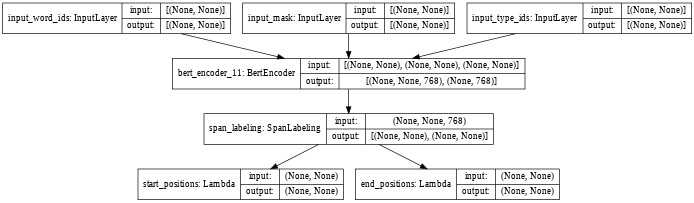

In [69]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)
tf.keras.utils.plot_model(bert_squad, show_shapes=True, dpi=48)


In [ ]:
from keras.layers import Dense, Input

x = Input

